# 04 k-Core Decomposition

In [1]:
# ── Path-Fix for Imports ───────────────────────────────────────────────────
import sys
from pathlib import Path
# Prepend parent directory (repo root) to sys.path
sys.path.insert(0, str(Path().resolve().parent))

# ── Standard Imports ───────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.graph_utils import load_clean_df, build_unweighted_graph, build_weighted_graph

sns.set(style="whitegrid")

## Analysis goes here…

In [2]:
# Parameters
THRESHOLD  = 0
START_DATE = "2023-04-14"
END_DATE   = "2023-05-31"
USE_CACHE  = True

In [3]:
# Load & Prepare Graph for k-Core
# Load directed graph and extract giant WCC, then convert to undirected
from networkx.algorithms.components import weakly_connected_components

df = load_clean_df(threshold=THRESHOLD, start_date=START_DATE, end_date=END_DATE)
G_dir = build_unweighted_graph(df, threshold=THRESHOLD,
                              start_date=START_DATE, end_date=END_DATE,
                              use_cache=USE_CACHE)
# Giant weakly-connected component
giant_wcc = max(weakly_connected_components(G_dir), key=len)
G = G_dir.subgraph(giant_wcc).copy().to_undirected()

print(f"Giant WCC (undirected) nodes: {G.number_of_nodes():,}, edges: {G.number_of_edges():,}")

Giant WCC (undirected) nodes: 215,727, edges: 356,954


In [5]:
# k-Core Decomposition
# Compute core numbers for each node\score_nums = nx.core_number(G)
# Count how many nodes in each k-shell (i.e., degree k-core membership)
score_nums = nx.core_number(G)
shell_counts = pd.Series(list(score_nums.values())).value_counts().sort_index()
shell_df = pd.DataFrame({"k": shell_counts.index, "count": shell_counts.values}).set_index("k")
display(shell_df)

,count
k,
1,106945
2,79321
3,19092
4,6810
5,2301
6,692
7,284
8,178
9,66


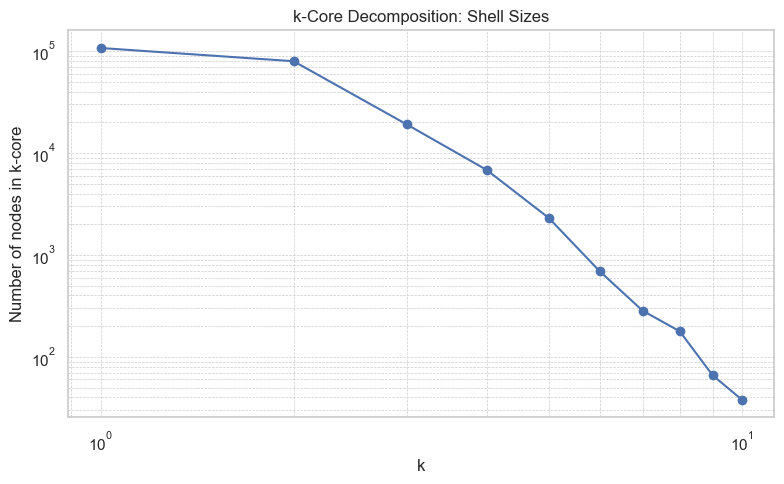

In [6]:
# Plot k-Shell Sizes vs k
plt.figure(figsize=(8,5))
plt.plot(shell_df.index, shell_df["count"], marker='o')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('Number of nodes in k-core')
plt.title('k-Core Decomposition: Shell Sizes')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

In [7]:
# Extract Innermost Core (max k)
k_max = shell_df.index.max()
print(f"Max k-core index k_max = {k_max}")
core_nodes = [n for n, k in score_nums.items() if k == k_max]
G_kmax = G.subgraph(core_nodes).copy()
print(f"Innermost core nodes: {len(core_nodes):,}, edges: {G_kmax.number_of_edges():,}")

Max k-core index k_max = 10
Innermost core nodes: 38, edges: 296


In [11]:
import pickle
# Define save path
dir_save = Path().resolve().parent / "data" / "clean" / "graph_cache"
file_path = dir_save / f"G_kcore_max{k_max}.gpickle"

# Write with Python’s pickle (fallback instead of networkx.write_gpickle)
with open(file_path, "wb") as f:
    pickle.dump(G_kmax, f)

print(f"Saved innermost core subgraph to {file_path}")

Saved innermost core subgraph to /Users/benedikt/Documents/_SABANCI/_Network Science/Project/NetSci_PEPE_code_repo/data/clean/graph_cache/G_kcore_max10.gpickle


## Summary of k-Core Decomposition (Notebook 04)

**1. Giant WCC (undirected)**  
- Nodes: 215 727  
- Edges: 356 954  

**2. k-Shell Sizes**  
| k-core (k) | # Nodes  |  
|:----------:|---------:|  
| 1          | 106 945  |  
| 2          |  79 321  |  
| 3          |  19 092  |  
| 4          |   6 810  |  
| 5          |   2 301  |  
| 6          |     692  |  
| 7          |     284  |  
| 8          |     178  |  
| 9          |      66  |  
| 10         |      38  |  

**3. Resilient Core**  
- **Maximum k:** 10 (no 11-core exists)  
- **Innermost core:** 38 nodes, 296 edges  
- Saved as `data/clean/graph_cache/G_kcore_max10.gpickle`



### 🔍 Interpretation

- **Rapid peeling:** the network shrinks from ~106 k nodes at k≥1 to only 38 at k≥10, showing a fast fall-off in local cohesion.  
- **Resilience threshold at k=10:** only 38 wallets maintain ≥10 distinct connections in the core—these are the most robust participants (likely exchanges, DEX routers, top whales).  
- **Tiny ultra-dense backbone:** 38 nodes with 296 mutual links form the “engine room” of PEPE transfers; removing them would critically fragment the network.  


### How we Continue building upon those results:

- **Community detection (Notebook 06):** explore sub-communities within the 10-core.  
- **Centrality analysis (Notebook 03):** rank the 38 core nodes to pinpoint true linchpins.  
- **Robustness simulations (Notebook 08):** test targeted removal of k-core nodes to quantify network fragility.  
